In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from datetime import datetime
from matplotlib import pyplot as plt

import seaborn as sns

import tensorflow as tf
#import tensorrt
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense
from keras.models import Sequential

from tensorflow.keras.optimizers import Adam, Nadam, AdamW
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
def mase(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    
    return mae_model / mae_naive if mae_naive != 0 else float('inf')



def printRegressionMetrics(y_true, y_pred):
    
    MAPE = metrics.mean_absolute_percentage_error(y_true, y_pred)
    MSE = metrics.mean_squared_error(y_true, y_pred)
    R2 = metrics.r2_score(y_true, y_pred)
    MASE = mase(y_true, y_pred)
    
    print('MSE:')
    print(MSE)
    print('MAPE:')
    print(MAPE)
    print('MASE:')
    print(MASE)
    print('R2:')
    print(R2)

NEW_MODEL = True
MODEL_NAME = 'MickaNet-BILSTM-V2'

In [31]:
WINDOW_SIZE = 24
x_frames = []
y_frames = []

In [32]:
data = pd.read_csv("./Dataset/dataOld.csv")
data = data.head(25000)

In [33]:
teste = data.copy()
teste["timestamp"] = teste["timestamp"] / 1000
teste["timestamp"] = teste['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
teste.reset_index(drop=True, inplace=True)

In [34]:
scaler_price = MinMaxScaler(feature_range=(0,1))
scaler_volume= MinMaxScaler(feature_range=(0,1))
scaler_trades = MinMaxScaler(feature_range=(0,1))

price_scaled = np.array(teste["price"]).copy()
volume_scaled = np.array(teste["volume"]).copy()
trades_scaled = np.array(teste["trades"]).copy()


teste['price'] = scaler_price.fit_transform(price_scaled.reshape(-1,1)).flatten()
teste['volume'] = scaler_volume.fit_transform(volume_scaled.reshape(-1,1)).flatten()
teste['trades'] = scaler_trades.fit_transform(trades_scaled.reshape(-1,1)).flatten()

In [35]:
teste = teste.set_index('timestamp')
teste

,volume,trades,price
timestamp,,,
2020-01-01 00:00:00,0.016864,0.027210,0.506509
2020-01-01 00:15:00,0.009364,0.016623,0.507818
2020-01-01 00:30:00,0.011861,0.019704,0.505414
2020-01-01 00:45:00,0.007188,0.011630,0.505980
2020-01-01 01:00:00,0.008107,0.017642,0.505084
...,...,...,...
2020-04-14 02:45:00,0.033094,0.050587,0.454141
2020-04-14 03:00:00,0.020906,0.036188,0.453304
2020-04-14 03:15:00,0.027197,0.038111,0.451211


In [36]:
teste.reset_index(drop=True, inplace=True)
teste

,volume,trades,price
0,0.016864,0.027210,0.506509
1,0.009364,0.016623,0.507818
2,0.011861,0.019704,0.505414
3,0.007188,0.011630,0.505980
4,0.008107,0.017642,0.505084
...,...,...,...
9995,0.033094,0.050587,0.454141
9996,0.020906,0.036188,0.453304
9997,0.027197,0.038111,0.451211
9998,0.027482,0.041679,0.451771


In [37]:
x_names = teste.columns.to_list()

x_data = teste[x_names].to_numpy()
y_data = teste['price'].to_numpy()

num_samples = len(teste) - WINDOW_SIZE

x_frames = np.zeros((num_samples, WINDOW_SIZE, len(x_names)))
y_frames = np.zeros((num_samples, 1))

for i in range(num_samples):
    x_frames[i] = x_data[i:i+WINDOW_SIZE] 
    y_frames[i] = y_data[i+WINDOW_SIZE]

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x_frames, y_frames, test_size=0.3, shuffle=False)

In [39]:
input = tf.keras.layers.Input(shape=(x_train.shape[1], 3), name ="input"
    )
x = tf.keras.layers.Bidirectional(LSTM(128, 
                                           return_sequences=True,
                                           kernel_initializer=tf.initializers.GlorotUniform(seed=42)))(input)
    
x = tf.keras.layers.Bidirectional(LSTM(64, 
                                           return_sequences=False,
                                           kernel_initializer=tf.initializers.GlorotUniform(seed=42)))(x)
    
x = tf.keras.layers.Dense(32 , activation="tanh", name ="dense_1")(x)
    
output = tf.keras.layers.Dense(1, name="last_dense")(x)
               
model_trained = tf.keras.Model(inputs=input, outputs=output)

In [40]:
model_trained.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 24, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 24, 256)        │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_dense (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,681 (1.16 MB)

 Trainable params: 303,681 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
if (NEW_MODEL == True):
          
    es = EarlyStopping(monitor='loss', mode='min', patience=50)


    cp = ModelCheckpoint(filepath=f'models/{MODEL_NAME}.weights.h5', 
                           save_weights_only=True, 
                           monitor='loss', 
                           mode='min', 
                           save_best_only=True)
    
    #Adamax(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, clipnorm=1)
    #Nadam(learning_rate=0.0001, beta_1=0.85, beta_2=0.989, epsilon=1e-06, clipnorm=1)
    
    opt = Nadam(learning_rate=0.0001, beta_1=0.85, beta_2=0.989, epsilon=1e-06, clipnorm=1)
    
    model_trained.compile(optimizer = opt, loss = 'mean_squared_error')
    
    history = model_trained.fit(x_train, 
                               y_train, 
                               validation_split=0.2, 
                               epochs=1000, 
                               verbose=1, 
                               callbacks=[cp, es], 
                               batch_size=64, 
                               shuffle=False)
    
    #np.save('models/history_model.npy', history.history)
    model_trained.load_weights(f'models/{MODEL_NAME}.weights.h5')
    model_trained.save(f'models/{MODEL_NAME}.keras')
else:
    model_trained = load_model(f'models/{MODEL_NAME}.keras')

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0893 - val_loss: 0.0022
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8574e-04 - val_loss: 0.0019
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7430e-04 - val_loss: 0.0016
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8840e-04 - val_loss: 0.0014
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9822e-04 - val_loss: 0.0014
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.0511e-04 - val_loss: 0.0015
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.1521e-04 - val_loss: 0.0016
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.3115e-04 - val_loss: 0.0018
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.5307e-04 - val_loss: 0.0019
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.7938e-04 - val_loss: 0.0020
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.0781e-04 - val_loss: 0.0020
Epoch 12/100

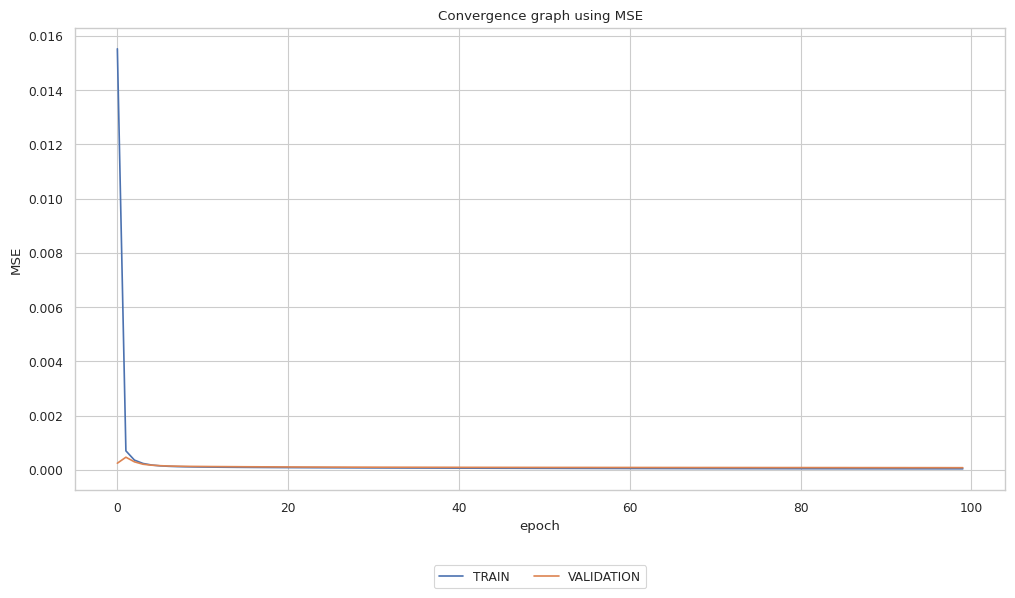

In [42]:
history=np.load('models/history_model.npy', allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

train_metric = history['loss']
valid_metric = history['val_loss']
name_metric = 'mse'

fig = plt.figure()

plt.plot(train_metric, label='TRAIN'), 
plt.plot(valid_metric, label='VALIDATION')
plt.ylabel(name_metric.upper())
plt.xlabel('epoch')
plt.title('Convergence graph using ' + name_metric.upper())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)

plt.show()

In [43]:
y_hat = model_trained.predict(x_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [44]:
y_train2 = scaler_price.inverse_transform(y_train.flatten().reshape(-1, 1))
y_test2 = scaler_price.inverse_transform(y_test.flatten().reshape(-1, 1))
y_hat2 = scaler_price.inverse_transform(y_hat.flatten().reshape(-1, 1))

In [45]:
#cria um data table com os valores reais e preditos
df_forecast = pd.DataFrame()
df_forecast['y_true'] = np.hstack((y_train2.flatten(), y_test2.flatten()))
df_forecast['y_hat'] = np.hstack((y_train2.flatten(), y_hat2.flatten()))

df_forecast.shape

(9976, 2)

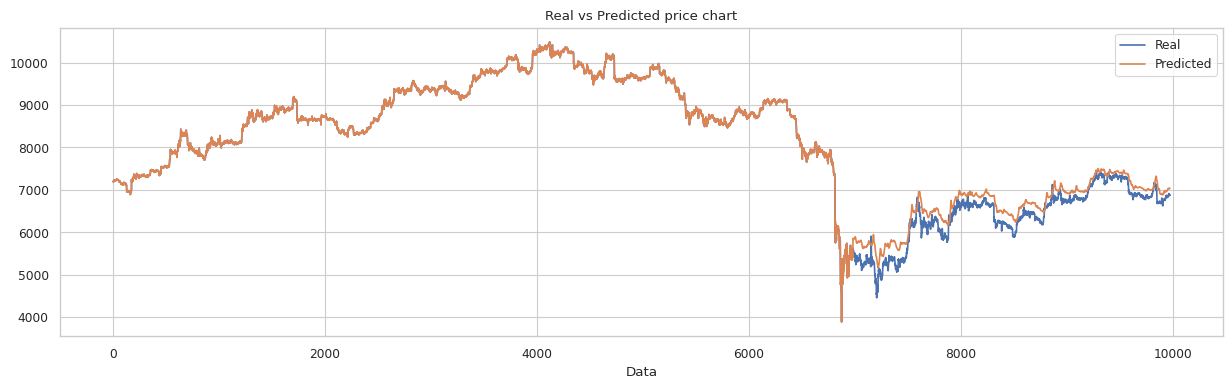

In [46]:
sns.set_theme(rc={'figure.figsize':(15, 4)})
sns.set_style('whitegrid')
sns.set_context('paper')

ax = df_forecast.plot(x_compat=True, style='-')
ax.set_xlabel("Data")
ax.legend(["Real", "Predicted"])
ax.set_title("Real vs Predicted price chart")

plt.grid(True)

plt.show()

plt.close()

In [47]:
printRegressionMetrics(y_test2, y_hat2)

MSE:
80111.42470042792
MAPE:
0.041288679335367284
MASE:
10.562375810870385
R2:
0.8023582686862146
